## MainQuest05(Kaggle주택 가격)
- 평가지표 : RMSE(Root-MSE)
- 제출방법 : notion에 github레포 주소 공유(ipynb)

### 01 데이터 이해 및 탐색
- trainset, 1168개 데이터, 81개 feature(feature가 너무 많음)
  - 일부 feature는 제거하는 것이 나을 수도 있음!
  - 심지어 일부 feature는 결측치도 많음!
- 시각화?
- 인사이트?
  - y값 로그, 루트 변환 통해 skewness 보니 로그변환 효과가 훨씬 좋아보임!

#### 01-01 데이터 탐색

In [ ]:
from google.colab import files

uploaded = files.upload()  # 파일 업로드 창이 뜸

# 업로드된 파일 이름 확인(로컬에서 파일 업로드)
for filename in uploaded.keys():
    print('업로드 완료:', filename)

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
업로드 완료: sample_submission.csv
업로드 완료: test.csv
업로드 완료: train.csv


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

house_df_org = pd.read_csv('train.csv') # 교재는 house_price.csv임
house_df = house_df_org.copy()
house_df.head(n=3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [2]:
dtype_counts = house_df.dtypes.value_counts()
print("\n--- 데이터 타입별 개수 ---")
print(dtype_counts)


--- 데이터 타입별 개수 ---
object     43
int64      35
float64     3
Name: count, dtype: int64


In [3]:
house_df.shape

(1168, 81)

##### 결측치 많은 상위 10개 피쳐 추출

In [4]:
house_df.isna().mean().sort_values(ascending=False)[:10]

,0
PoolQC,0.994863
MiscFeature,0.958904
Alley,0.940068
Fence,0.805651
MasVnrType,0.594178
FireplaceQu,0.466610
LotFrontage,0.186644
GarageQual,0.059075
GarageFinish,0.059075
GarageType,0.059075


In [21]:
missing_top_10 = house_df.isna().mean().sort_values(ascending=False)[:10]
missing_top_10.name = 'missing_percentage' # Series에 이름 부여

# 10개 column명 추
top_10_column_names = missing_top_10.index
data_types_top_10 = house_df.dtypes.loc[top_10_column_names]
data_types_top_10.name = 'dtype' # Series에 이름 부여

combined_info_df = pd.DataFrame({'missing_percentage': missing_top_10, 'dtype': data_types_top_10})
print("--- 결측치 상위 10개 컬럼과 데이터 타입 ---")
print(combined_info_df)


--- 결측치 상위 10개 컬럼과 데이터 타입 ---
              missing_percentage   dtype
GarageCond              0.059075  object
GarageQual              0.059075  object
GarageType              0.059075  object
GarageFinish            0.059075  object
BsmtExposure            0.020548  object
BsmtFinType2            0.020548  object
BsmtCond                0.019692  object
BsmtQual                0.019692  object
BsmtFinType1            0.019692  object
Electrical              0.000856  object


##### 조금 다른 접근
- 교재에서는 결측치 46%인 'FireplaceQu'를 제거하지 않음(범주형 변수 6개 제거)
  - 이 변수를 제거하고 진행해보겠음
  - Gd,TA,Fa(27),Ex(20),Po(16) 처럼 몇몇 컬럼이 가짓수가 너무 적음
- 기대효과
  - One hot-encoding시 범주 개수가 많아질 수 있으므로, 결측치 46%인 feature를 빼는게 나을 수도 있음   
  (업무상 주요하다는 consensus가 이뤄진 항목이 아니라면)

In [6]:
print(house_df['FireplaceQu'].value_counts()) # 결측치 46% 이상인데, 교재에서는 제거 안함!()
print(house_df['MasVnrType'].value_counts()) # 결측치 50% 이상

FireplaceQu
Gd    314
TA    246
Fa     27
Ex     20
Po     16
Name: count, dtype: int64
MasVnrType
BrkFace    359
Stone      104
BrkCmn      11
Name: count, dtype: int64


#### 01-02 시각화

##### 교재와 다르게 'FirePlaceQu'제거 정당화 될만한지?
- 분명 FireplaceQu의 범주 따른 유의차가 보이긴 하나, outlier도 다수 관측됨
  - 교재에서는, 아마 FireplaceQu제거 해보고, 넣어보고 tuning 해보지 않았을까 추측됨
  - 그렇지만 다른 길을 가보겠음(Olympic 정신)
  - 만약, 시간 여유가 되면.. 이 Feature넣어보고 다시 모형 tuning해 보는걸로!



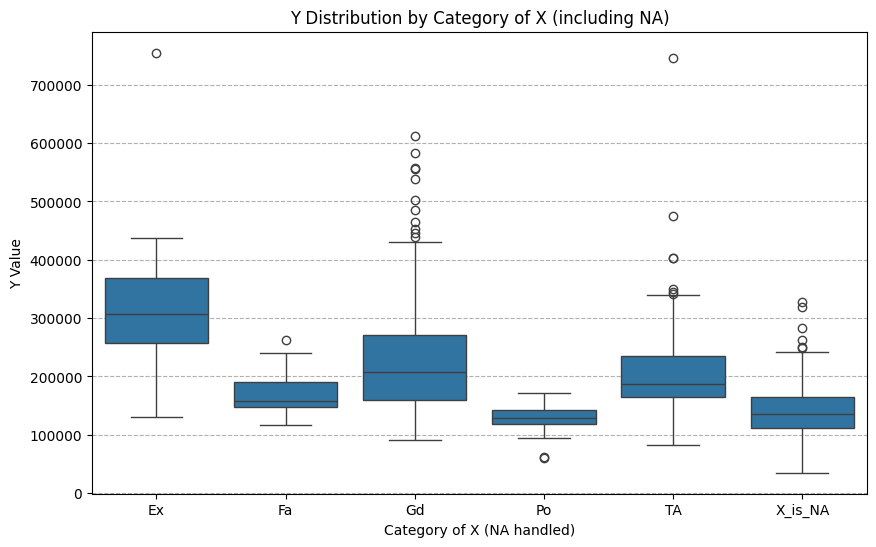

In [7]:
check_df = house_df[['FireplaceQu','SalePrice']]
check_df['FireplaceQu'] = check_df['FireplaceQu'].fillna('X_is_NA')

plt.figure(figsize=(10, 6))
sns.boxplot(x='FireplaceQu', y='SalePrice', data=check_df, order=sorted(check_df['FireplaceQu'].unique())) # order로 순서 지정 가능
plt.title('Y Distribution by Category of X (including NA)')
plt.xlabel('Category of X (NA handled)')
plt.ylabel('Y Value')
plt.grid(axis='y', linestyle='--')
plt.show()


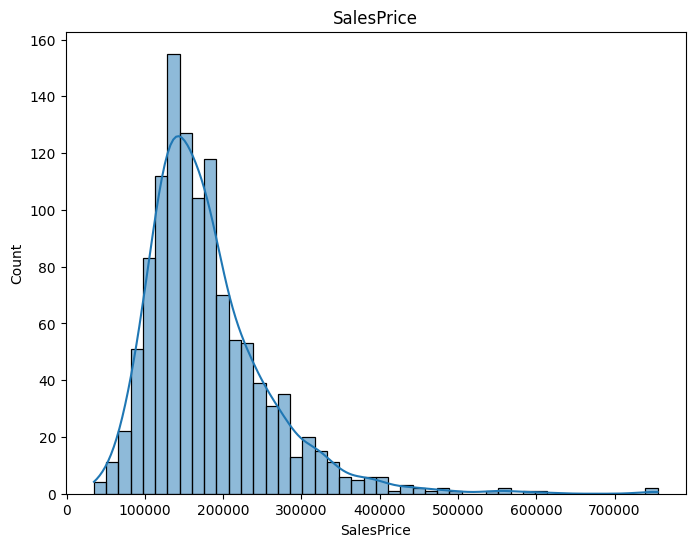

In [8]:
# target변수 분포 확인!
# 확인해보니 root나 log 변환 등이 필요해 보임!

plt.figure(figsize=(8, 6))

sns.histplot(data = house_df['SalePrice'],kde = 'True')

plt.title('SalesPrice')
plt.xlabel('SalesPrice')
plt.ylabel('Count')
plt.show()

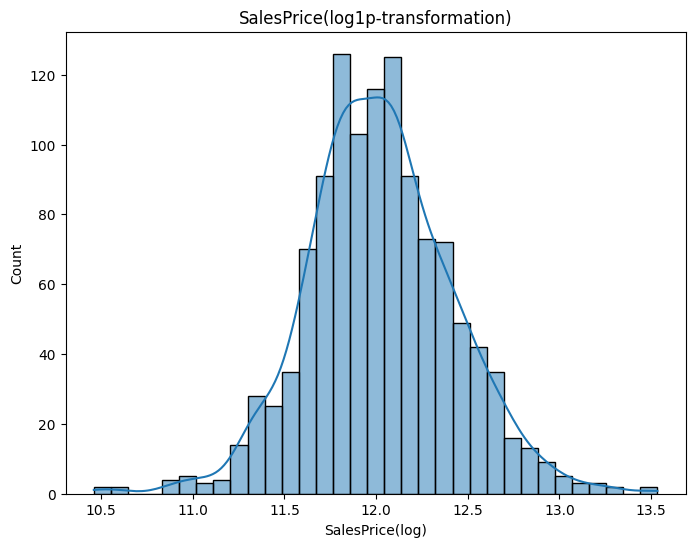

In [9]:
# target변수 분포 확인!
# 확인해보니 root나 log 변환 등이 필요해 보임!

plt.figure(figsize=(8, 6))

sns.histplot(data = np.log1p(house_df['SalePrice']),kde='True')

plt.title('SalesPrice(log1p-transformation)')
plt.xlabel('SalesPrice(log)')
plt.ylabel('Count')
plt.show()

In [10]:
from scipy.stats import skew
house_df['SalePrice'].skew() # 1.95로 아주 심하진 않지만.. transformation 해보면 어떨까?

np.float64(1.957766064521197)

#### (인사이트) 01-03 Skewness 통해 transformation 효과 체크!
- root보단 log가 확실히 나아보임

In [11]:
np.log1p(house_df['SalePrice']).skew() # skewness가 0.08로 거의 평균=중간값.. 즉 대칭인 형태로 크게 완화됨 확인!

np.float64(0.08618330538751448)

In [12]:
np.sqrt(house_df['SalePrice']).skew() # skewness가 0.94로 별로 완화 안되었음! 즉 log-transformation이 훨씬 나아보임!

np.float64(0.9425712028656278)

### 02 데이터 전처리 과정
- 결측치 및 이상치 처리
- 스케일링 과정, 인코딩?
- Feature-engineering?(심화)

#### 02-01 결측치 및 이상치 처리
- 일단 결측치 너무 많은 변수 제거
  - PoolQC(99.5%),MiscFeature(95.8%),Alley(94%),Fence(80%),MasVrnType(59.4%), FireplaceQu(46.6%)
  - FireplaceQu는 교재에서는 제거 안함(이거 확인 필요)
- 결측치 평균(교재)대신 중앙값으로 대치
  - 유의미한 차이는 없을 것으로 판단되나, outlier에 조금 더 강건할 것으로 생각됨

##### 수치형 변수 결측치 확인
- LotFrontage (218개, 18%)
- GarageYrBlt (69개)
- MasVnrArea (8개)

In [13]:
numerical_df = house_df.select_dtypes(include=['int64', 'float64'])
numerical_df.isna().sum().sort_values(ascending=False)[:5]

,0
LotFrontage,218
GarageYrBlt,69
MasVnrArea,8
LotArea,0
MSSubClass,0


#### 02-02 스케일링?
- 수치형 데이터와 타겟(SalePrice)간의 관계
- 범주형과 타겟(SalePrice)간의 관계

In [14]:
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df = house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu'], axis=1) # MasVnrType(이거 빼먹어서 몇 시간 찾음..)

# 숫자형 Null은 중앙값으로 대체

num_cols = house_df.select_dtypes(include=['number']).columns
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].median())

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


##### 수치형 vs 타겟
- 고민해 볼 지점이 굉장히 많음
 - 3SsnPorch, ScreenPorch,PoolArea, MiscVal 처럼 log(SalePrice)와 관련이 아예 없는 변수 처리가 애매함
 - BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Fireplaces 처럼 수치형으로 되어 있으나   범주형으로 처리하는게 맞는 것 처럼 보이는 경우?(tree기반 모형은 이런 부분에 대해 robust함)
- MoSold? (판매된 달?)
 - 다행히 뚜렷한 경향성은 발견되지 않음. 경향성 있다면 sin/cos 활용해 변환하는 feature-engineering 작업 필요

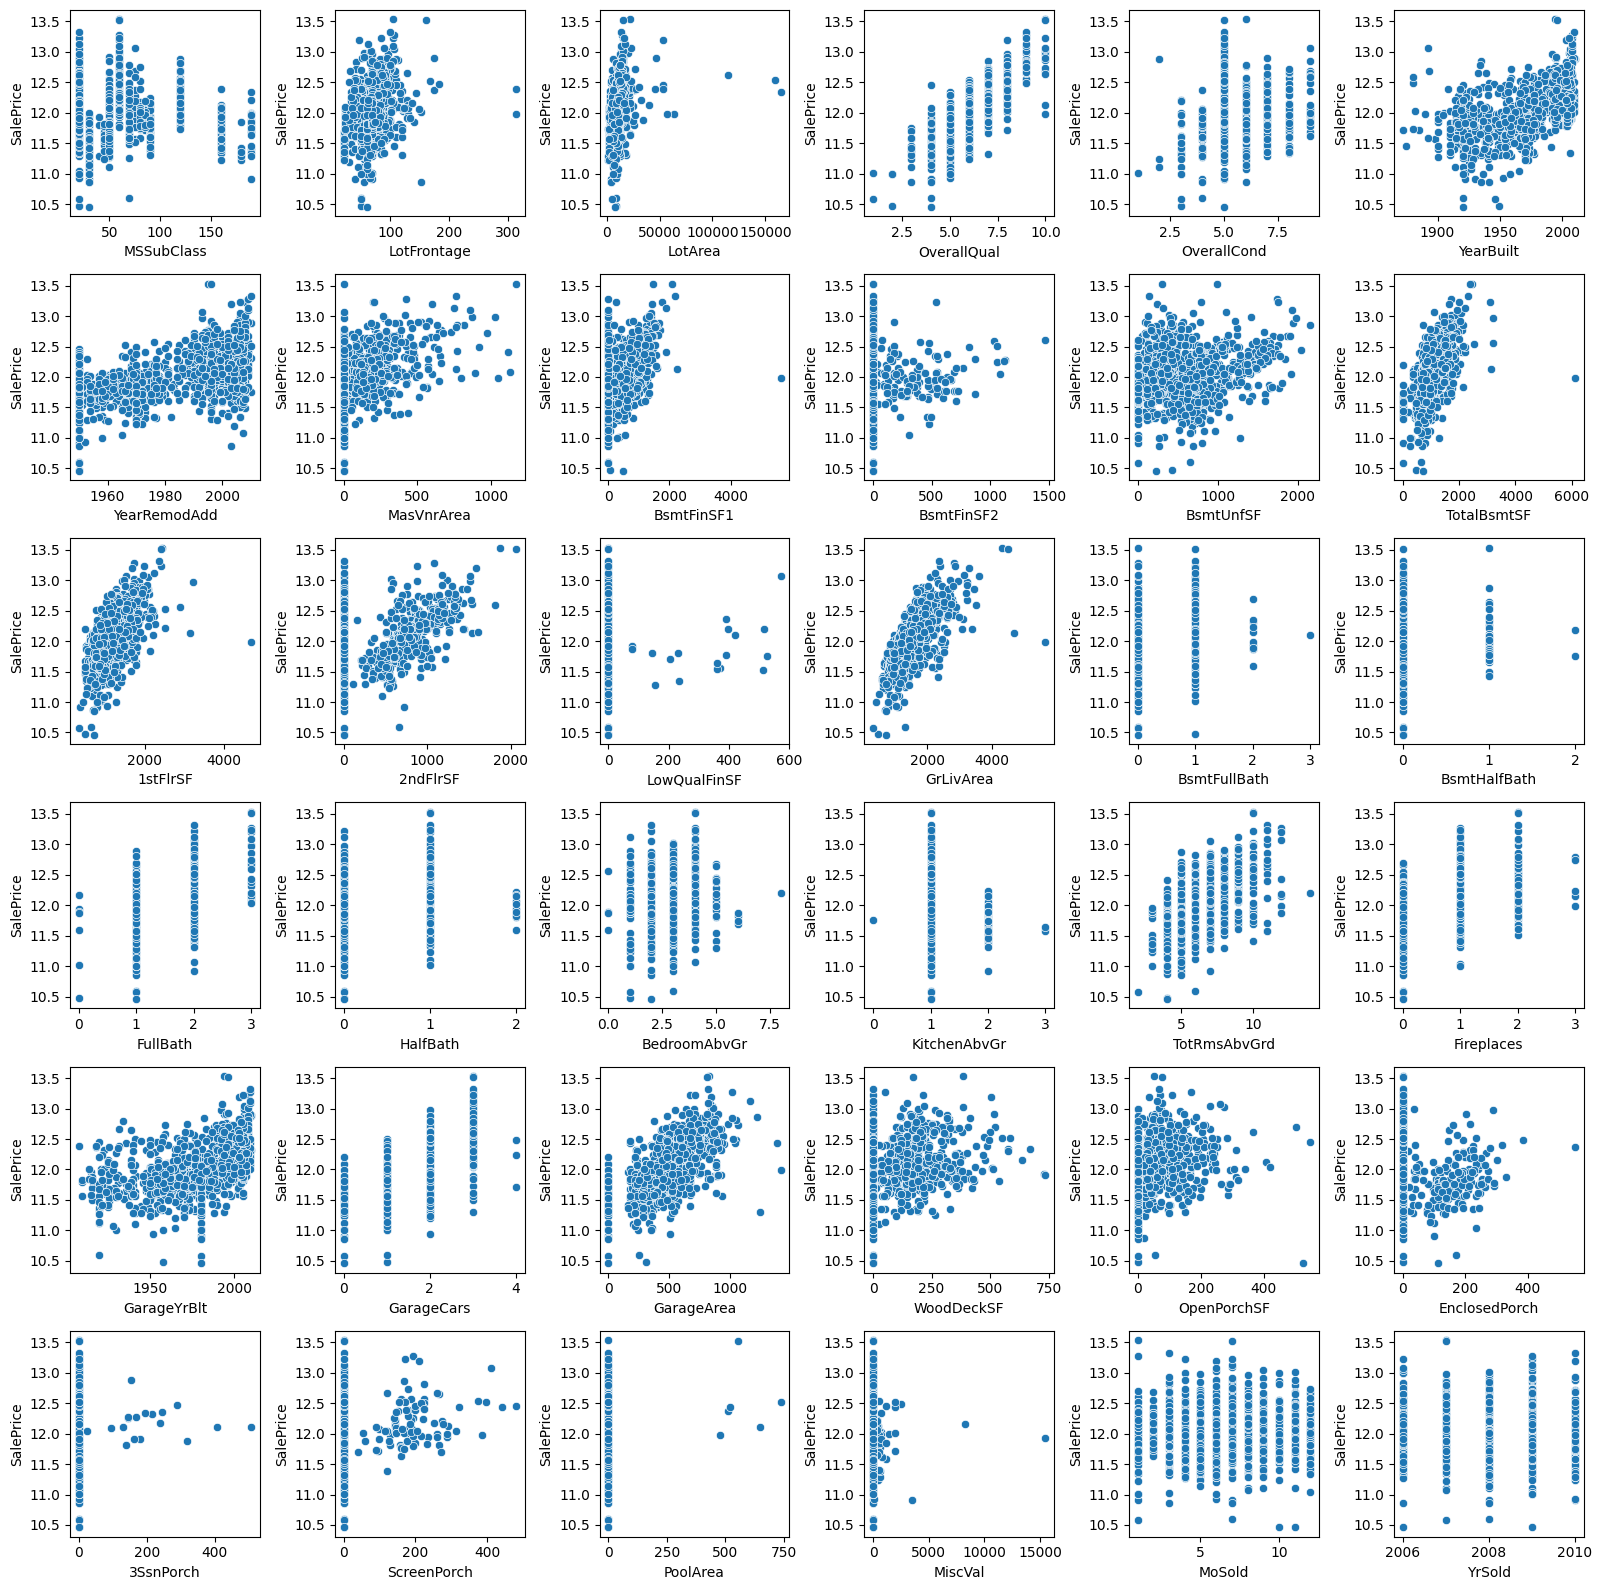

In [16]:

x_num_cols = house_df.select_dtypes(include=['number']).columns[house_df.select_dtypes(include=['number']).columns!='SalePrice']
# len(x_num_cols)
# 수치형 X_feature가 딱 36개!

fig, axs = plt.subplots(figsize = (16,16), ncols = 6, nrows = 6)

for i, numeric_feature in enumerate(x_num_cols):
  row = int(i/6)
  col = i%6

  sns.scatterplot(x = numeric_feature, y='SalePrice', data=house_df, ax = axs[row][col])

# 모든 subplot이 그려진 후 레이아웃 자동 조정 (제목이나 레이블이 겹치는 것을 방지)
plt.tight_layout()
plt.show()

In [17]:
# 3SsnPorch가 0보다 큰 비율?
ratio1 = len(house_df[house_df['3SsnPorch'] > 0])/len(house_df)
# ScreenPorch가 0보다 큰 비율
ratio2 = len(house_df[house_df['ScreenPorch'] > 0])/len(house_df)
# PoolArea가 0보다 큰 비율
ratio3 = len(house_df[house_df['PoolArea'] > 0]) / len(house_df)
# MiscVal가 0보다 큰 비율
ratio4 = len(house_df[house_df['MiscVal'] > 0]) / len(house_df)

print(f'3SsnPorch가 0초과하는 비율: {round(ratio1,2)*100}%')
print(f'ScreenPorch가 0초과하는 비율: {round(ratio2,2)*100}%')
print(f'PoolArea가 0초과하는 비율: {round(ratio3,2)*100}%')
print(f'MiscVal가 0초과하는 비율: {round(ratio4,2)*100}%')


3SsnPorch가 0초과하는 비율: 2.0%
ScreenPorch가 0초과하는 비율: 8.0%
PoolArea가 0초과하는 비율: 1.0%
MiscVal가 0초과하는 비율: 4.0%


####(주의!!) 일반화된 방식의 OneHotEncoding!
- 원래 비효율적이지만, 향후 OneHotEncoding 외에 일반화된 방식의 모델링에 쓰이는 방식대로 정리함
- sklearn 모듈에서 쓰이는 구조로는 pd.get_dummies() 쓰는게 제일 편리함!

In [ ]:
# temp = house_df.copy() # temp로 할당해 둠!
# # 교재의 house_df는 이제 temp에 해당된다고 간주!(단,FireplaceQu가 제거된 상황만 다름!)

# print('get_dummies() 수행 전 데이터 Shape:', temp.shape)
# temp_ohe = pd.get_dummies(temp)
# print('get_dummies() 수행 후 데이터 Shape:', temp_ohe.shape)

# null_column_count = temp_ohe.isnull().sum()[temp_ohe.isnull().sum() > 0]
# print('## Null 피처의 Type :\n', temp_ohe.dtypes[null_column_count.index])
# print('FireplaceQu 제거 시도했기에, 267개 feature!(기타 feature고민 반영 전!)')

##### 평가함수 정의(RMSE) - 교재

In [18]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__,'로그 변환된 RMSE:',np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

###### OnehotEncoder와 꼬여서 함수 refactorying함(from Gemini)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 함수 1: 회귀 계수 상위/하위 N개 추출 (내부에서 X_features_global.columns 사용)
# 이 함수는 visualize_coefficients_simple 내부에서만 사용될 것이므로,
# visualize_coefficients_simple에 전달된 X_features를 사용하도록 할 수 있습니다.
# 하지만 교재의 단순성을 살리기 위해, visualize_coefficients_simple 함수가
# 호출될 때 X_features가 올바른 스코프에 있도록 기대하는 형태로 두겠습니다.
# (더 나은 방법은 아래 visualize_coefficients_simple에서 feature_names를 전달하는 것입니다.)

def get_top_bottom_coef_original_style(model, current_X_features_columns, top_n=10):
    """
    교재 스타일과 유사하게, 모델과 현재 사용 중인 X_features의 컬럼명을 받아 계수 반환
    """
    if not hasattr(model, 'coef_'):
        # LightGBM 같은 모델은 coef_ 대신 feature_importances_를 가집니다.
        # 여기서는 선형 모델 계열만 다룬다고 가정합니다.
        print(f"주의: {model.__class__.__name__} 모델은 .coef_ 속성이 없습니다. (선형 모델이 아닐 수 있음)")
        return pd.Series(dtype='float64'), pd.Series(dtype='float64') # 빈 Series 반환

    # Lasso의 경우 coef_가 1차원 배열이 아닐 수 있음 (다중 타겟 문제 등)
    # 여기서는 coef_가 1차원 배열이라고 가정합니다. (일반적인 회귀)
    coef_values = model.coef_
    if coef_values.ndim > 1: # 다중 출력 Lasso 등의 경우 (예: MultiTaskLasso)
        # 간단히 첫 번째 출력에 대한 계수만 사용하거나, 평균을 내거나, 혹은 에러 처리
        # 여기서는 첫 번째 출력의 계수만 사용 (상황에 따라 수정 필요)
        print(f"주의: {model.__class__.__name__} 모델의 coef_가 다차원입니다. 첫 번째 결과만 사용합니다.")
        coef_values = coef_values[0]

    if len(coef_values) != len(current_X_features_columns):
        print(f"오류: {model.__class__.__name__} 모델 계수 개수({len(coef_values)})와 "
              f"X_features 컬럼 개수({len(current_X_features_columns)})가 일치하지 않습니다!")
        return pd.Series(dtype='float64'), pd.Series(dtype='float64')

    coef = pd.Series(data=coef_values, index=current_X_features_columns)

    coef_high = coef.sort_values(ascending=False).head(top_n)
    coef_low = coef.sort_values(ascending=False).tail(top_n)
    return coef_high, coef_low

# 함수 2: 여러 모델의 회귀 계수 시각화 (교재 스타일 + X_features 명시적 전달)
def visualize_coefficients_simple(models_list, X_features_df_for_columns, fig_title="Model Coefficients"):
    """
    여러 선형 모델의 회귀 계수를 시각화합니다.
    모든 모델은 동일한 X_features_df_for_columns로 학습되었다고 가정합니다.

    Args:
        models_list: [model_obj1, model_obj2, ...] 형태의 학습된 선형 모델 객체 리스트.
        X_features_df_for_columns: 모델 학습에 사용된 X 피처 데이터프레임 (컬럼명 추출용).
        fig_title: 그림 전체의 제목.
    """
    num_models = len(models_list)

    if num_models == 0:
        print("시각화할 모델이 없습니다.")
        return

    # 교재의 subplot 생성 방식 유지 (ncols=3 대신 len(models_list))
    fig, axs = plt.subplots(figsize=(16, 8), nrows=1, ncols=num_models)
    if num_models == 1: # 단일 모델일 경우 axs가 배열이 아니므로 리스트로 만듦
        axs = [axs]

    fig.tight_layout() # 먼저 호출하여 기본적인 간격 조정

    for i_num, model in enumerate(models_list):
        ax = axs[i_num]
        # 현재 X_features_df_for_columns에서 컬럼명을 가져와 get_top_bottom_coef_original_style에 전달
        coef_high, coef_low = get_top_bottom_coef_original_style(model, X_features_df_for_columns.columns)

        if coef_high.empty and coef_low.empty: # get_top_bottom_coef_original_style에서 빈 Series 반환 시
            ax.set_title(model.__class__.__name__ + ' (계수 없음)', size=15) # 폰트 크기 약간 줄임
            ax.text(0.5, 0.5, 'No coefficients to display.',
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            continue # 다음 모델로

        coef_concat = pd.concat([coef_high, coef_low])

        ax.set_title(model.__class__.__name__ + ' Coefficients', size=15) # 폰트 크기 약간 줄임
        # 교재의 tick_params 유지 (필요시 주석 처리하거나 값 조절)
        ax.tick_params(axis="y", direction="in", pad=-120)
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(12) # 폰트 크기 약간 줄임 (교재는 22였음)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=ax)

    plt.show()

In [25]:
# 교재에서는 sklearn 기반 방법이어서 pd.get_dummies를 바로 사용했는데..좀 더 일반화된 방법 사용해보겠음
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

temp = house_df.copy()

## 01 x,y, target 분리
y_target = temp['SalePrice']
X_features_raw = temp.drop('SalePrice', axis=1)

## 02 학습 데이터와 테스트 데이터 분리 (가공되지 않은 X 피처 사용)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_features_raw, y_target, test_size=0.2, random_state=156)

# 3. X_train_raw 에서만 범주형/수치형 피처 구분 및 전처리기 학습(fit)
categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train_raw.select_dtypes(include=np.number).columns.tolist()

# 예: OneHotEncoder 학습
# sparse_output=False: 결과를 NumPy 배열로 반환 (True면 희소 행렬)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop=None) # drop=None으로 모든 카테고리 유지
if categorical_features: # 범주형 피처가 있을 경우에만 실행
    ohe.fit(X_train_raw[categorical_features])
    print("OneHotEncoder 학습 완료.\n")
else:
    print("범주형 피처가 없어 OneHotEncoder 학습을 건너뜁니다.\n")

# 4. 학습된 전처리기를 사용하여 X_train_raw 와 X_test_raw 모두 변환(transform)
# 수치형 피처는 그대로 가져옴 (나중에 스케일링 등을 추가할 수 있음)
X_train_numerical_part = X_train_raw[numerical_features].copy()
X_test_numerical_part = X_test_raw[numerical_features].copy()

# 인덱스 리셋 (나중에 pd.concat 시 인덱스 정렬 문제를 피하기 위함)
X_train_numerical_part.reset_index(drop=True, inplace=True)
X_test_numerical_part.reset_index(drop=True, inplace=True)

if categorical_features: # 범주형 피처가 있을 경우에만 실행
    # Train 데이터의 범주형 피처 변환
    X_train_categorical_ohe_array = ohe.transform(X_train_raw[categorical_features])
    # 변환된 더미 변수들의 컬럼 이름 가져오기
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    # NumPy 배열을 DataFrame으로 변환 (인덱스 리셋)
    X_train_categorical_df = pd.DataFrame(X_train_categorical_ohe_array, columns=ohe_feature_names)

    # Test 데이터의 범주형 피처 변환
    X_test_categorical_ohe_array = ohe.transform(X_test_raw[categorical_features])
    # DataFrame으로 변환 (인덱스 리셋)
    X_test_categorical_df = pd.DataFrame(X_test_categorical_ohe_array, columns=ohe_feature_names)

    # 5. 최종 X_train, X_test 정의 (수치형 + 원-핫 인코딩된 범주형 결합)
    X_train = pd.concat([X_train_numerical_part, X_train_categorical_df], axis=1)
    X_test = pd.concat([X_test_numerical_part, X_test_categorical_df], axis=1)
else: # 범주형 피처가 없는 경우
    X_train = X_train_numerical_part
    X_test = X_test_numerical_part



OneHotEncoder 학습 완료.



In [26]:
X_train_categorical_df.shape, X_train_numerical_part.shape

((934, 233), (934, 36))

In [27]:
X_train.shape, X_test.shape

((934, 269), (234, 269))

### 03 모델 선택 및 비교
- 선형, Ridge, Lasso 비교
- RandomForest, XGBoost, LightGBM 등 비교
- 변수제거 여부?

#### 03-01 선형회귀, Ridge, Lasso

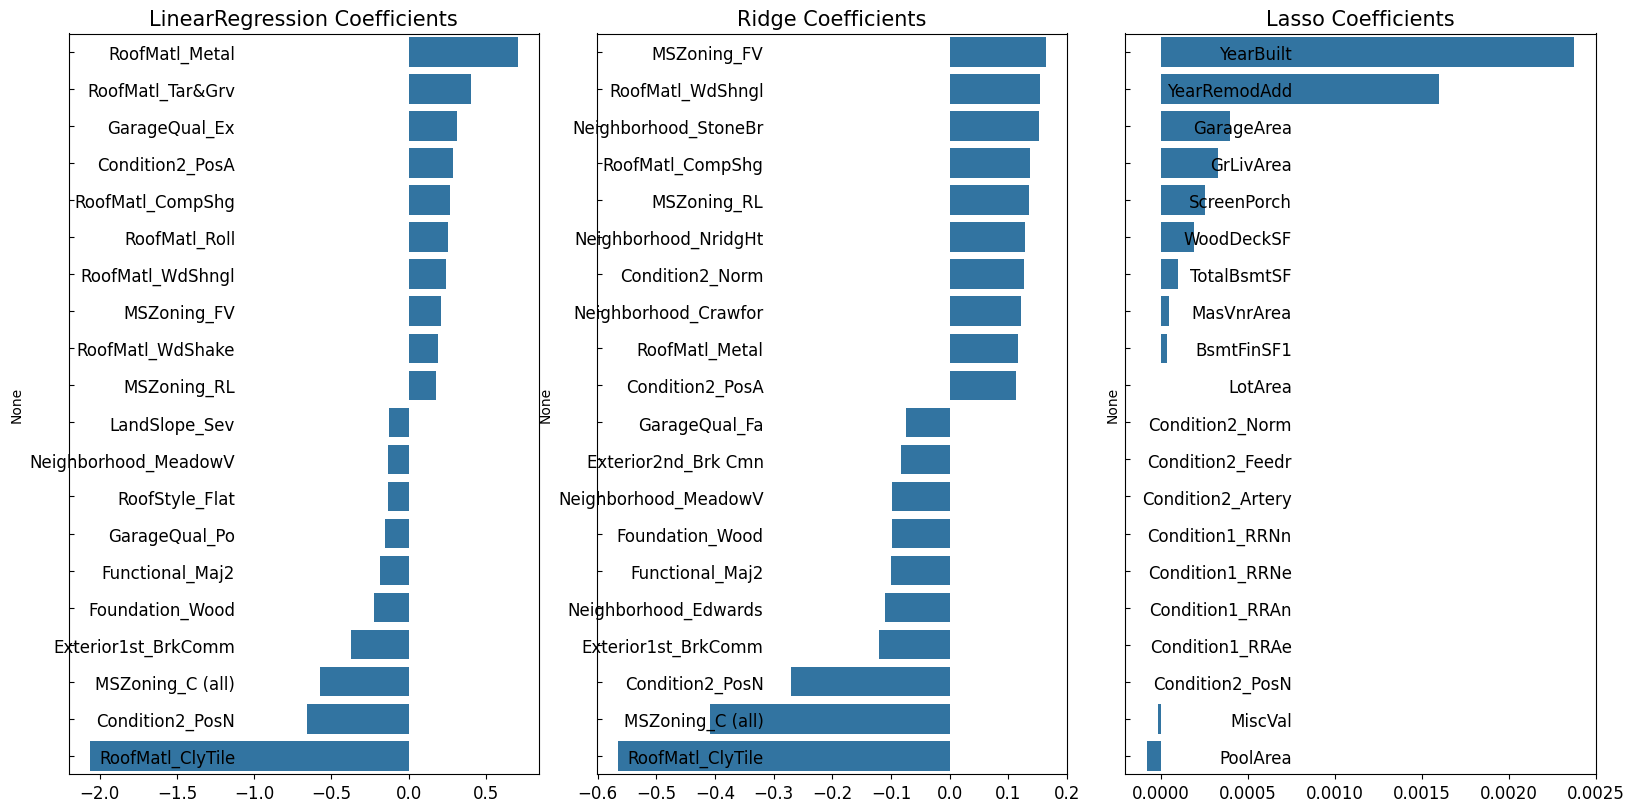

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# LinearRegression, Ridge, Lasson 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

visualize_coefficients_simple(models, X_train)

In [ ]:
#####
# LinearRegression 로그 변환된 RMSE: 0.129
# Ridge 로그 변환된 RMSE: 0.132
# Lasso 로그 변환된 RMSE: 0.177
# [np.float64(0.12939174342648851),
#  np.float64(0.13225934654474936),
#  np.float64(0.17732753939298992)]

#### 03-02 RandomForest, XGboost, LightGBM 적용
- 위의 LinearRegression, Ridge, Lasso와 비교
- hyperparameter 최적화 전
  - RandomForestRegressor 로그 변환된 RMSE: 0.142
  - LGBMRegressor 로그 변환된 RMSE: 0.129
  - XGBRegressor 로그 변환된 RMSE: 0.138

In [29]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import time

st = time.time()

## train/test는 그대로임!

# LinearRegression, Ridge, Lasson 학습, 예측, 평가
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train,y_train)
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_train,y_train)
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train,y_train)

ed = time.time()

models = [rf_reg,lgbm_reg,xgb_reg]
get_rmses(models)

print(f'Tree기반모델 : {round(ed-st,2)}초')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2928
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 160
[LightGBM] [Info] Start training from score 12.024957
RandomForestRegressor 로그 변환된 RMSE: 0.14
LGBMRegressor 로그 변환된 RMSE: 0.132
XGBRegressor 로그 변환된 RMSE: 0.136
Tree기반모델 : 4.51초


#### 03-03 위의 애매한 변수들 제거하는게 나은지 CV로 검증?!
- 3SsnPorch, ScreenPorch,PoolArea, MiscVal 제거할지
- 아니면 0/1로 encoding 할지 여부
 - (이 부분은 인터넷 찾아보니) feature 변형하고, 변수제거 여부 CV 하는게, 변수 제거 여부를 CV로 먼저 따지는 것 보다 먼저 낫다해서 그 단계를 밟겠음.
 - 사실 왜도(skewness)가 심하면, 모델이 최적의 성능을 내기 어렵기에, 모델이 최적의 성능을 낼 수 있도록 feature 변형한 상태에서, 변수 제거 여부 검토하는게 맞음!
- (주의) train_set의 왜도 > 1 컬럼을 '명시적'으로 test_set에 반영할 것
 - 예를 들어 train_set의 어느 컬럼이 왜도가 10이고 test가 -2라 해서 그걸 신경쓸 필요는 없음

In [30]:
from scipy.stats import skew
features_index = temp.dtypes[temp.dtypes != 'object'].index
skew_features = temp[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 왜도가 1이상인 피처를 로그 변환
temp[skew_features_top.index] = np.log1p(temp[skew_features_top.index])

MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
BsmtHalfBath      4.133732
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.785666
OpenPorchSF       2.454159
MasVnrArea        2.420783
BsmtFinSF1        1.881057
TotalBsmtSF       1.864686
WoodDeckSF        1.546567
1stFlrSF          1.488257
GrLivArea         1.474257
MSSubClass        1.391605
dtype: float64


##### 아웃라이어 확인!
- 교재에서는 'FireplaceQu' 제거 안했음, 그래서 'GrLivArea'가 Linear/Ridge/Lasso에서 모두 계수 영향도가 컸음

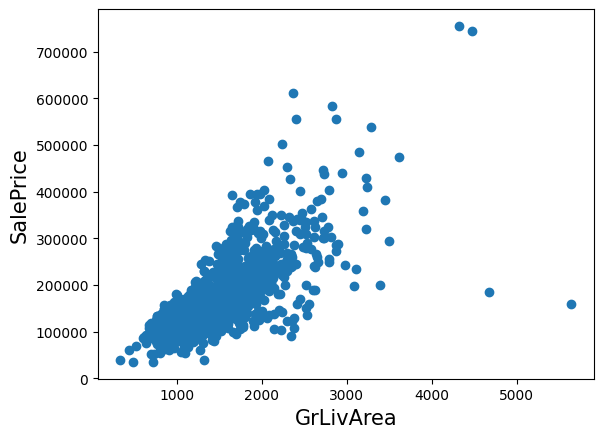

In [31]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

##### (주의!) 교재에서는, train/test Full-set이 있는 것 같음!

In [32]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = temp['GrLivArea'] > np.log1p(4000)
cond2 = temp['SalePrice'] < np.log1p(500000)
outlier_index = temp[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)

# DataFrame의 인덱스 이용해 이상치 레코드 삭제

temp = temp.drop(outlier_index, axis=0)
print('이상치 삭제 후 temp의 shape:', temp.shape)

아웃라이어 레코드 index : [ 64 373]
이상치 삭제 후 temp의 shape: (1166, 74)


In [35]:
# 교재에서는 sklearn 기반 방법이어서 pd.get_dummies를 바로 사용했는데..좀 더 일반화된 방법 사용해보겠음(차라리 함수화 하는게 나을 듯..)
# 데이터셋 다시 train/test 만들어야 함!
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코등 적용, 피처/타깃 데이터 세트 생성

from sklearn.preprocessing import OneHotEncoder

## 01 x,y, target 분리
y_target = temp['SalePrice'] # 여기서의 temp는 log1p 변환이 된(왜도가 높은 수치형 데이터에 대해) 데이터임!(주의!!)
X_features_raw = temp.drop('SalePrice', axis=1)

## 02 학습 데이터와 테스트 데이터 분리 (가공되지 않은 X 피처 사용)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_features_raw, y_target, test_size=0.2, random_state=156)

# 3. X_train_raw 에서만 범주형/수치형 피처 구분 및 전처리기 학습(fit)
categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train_raw.select_dtypes(include=np.number).columns.tolist()

# 예: OneHotEncoder 학습
# sparse_output=False: 결과를 NumPy 배열로 반환 (True면 희소 행렬)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop=None) # drop=None으로 모든 카테고리 유지
if categorical_features: # 범주형 피처가 있을 경우에만 실행
    ohe.fit(X_train_raw[categorical_features])
    print("OneHotEncoder 학습 완료.\n")
else:
    print("범주형 피처가 없어 OneHotEncoder 학습을 건너뜁니다.\n")

# 4. 학습된 전처리기를 사용하여 X_train_raw 와 X_test_raw 모두 변환(transform)
# 수치형 피처는 그대로 가져옴 (나중에 스케일링 등을 추가할 수 있음)
X_train_numerical_part = X_train_raw[numerical_features].copy()
X_test_numerical_part = X_test_raw[numerical_features].copy()

# 인덱스 리셋 (나중에 pd.concat 시 인덱스 정렬 문제를 피하기 위함)
X_train_numerical_part.reset_index(drop=True, inplace=True)
X_test_numerical_part.reset_index(drop=True, inplace=True)

if categorical_features: # 범주형 피처가 있을 경우에만 실행
    # Train 데이터의 범주형 피처 변환
    X_train_categorical_ohe_array = ohe.transform(X_train_raw[categorical_features])
    # 변환된 더미 변수들의 컬럼 이름 가져오기
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    # NumPy 배열을 DataFrame으로 변환 (인덱스 리셋)
    X_train_categorical_df = pd.DataFrame(X_train_categorical_ohe_array, columns=ohe_feature_names)

    # Test 데이터의 범주형 피처 변환
    X_test_categorical_ohe_array = ohe.transform(X_test_raw[categorical_features])
    # DataFrame으로 변환 (인덱스 리셋)
    X_test_categorical_df = pd.DataFrame(X_test_categorical_ohe_array, columns=ohe_feature_names)

    # 5. 최종 X_train, X_test 정의 (수치형 + 원-핫 인코딩된 범주형 결합)
    X_train = pd.concat([X_train_numerical_part, X_train_categorical_df], axis=1)
    X_test = pd.concat([X_test_numerical_part, X_test_categorical_df], axis=1)
else: # 범주형 피처가 없는 경우
    X_train = X_train_numerical_part
    X_test = X_test_numerical_part


OneHotEncoder 학습 완료.



In [150]:
temp.shape

(1166, 74)

In [33]:
temp.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,3.044522,RL,4.248495,8.908018,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.000000,7,2008,WD,Normal,11.813037
1,4.510860,RL,4.110874,9.287394,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.000000,3,2009,WD,Alloca,12.095147
2,3.044522,RL,4.007333,9.533293,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.000000,7,2006,WD,Normal,12.078245
3,3.044522,RL,4.543295,9.395242,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.000000,12,2007,New,Partial,12.669810
4,3.931826,RL,4.110874,8.995289,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0.0,0.0,0.0,0.0,7.601402,7,2007,WD,Normal,11.719134


In [37]:
y_train.head()

,SalePrice
167,12.341482
1089,11.925042
527,12.429220
459,11.686887
1065,12.850557


##### 변수 제거 여부 확인?! CV사용
- 성능 차이 미미해서, '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal 제거하는 방향으로

In [39]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder # 혹시 모를 다른 범주형 변수 처리를 위해

# 비교 대상이 되는 "애매한" 변수들 리스트
ambiguous_cols = ['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# 타겟 변수 및 기본 X 피처 정의
TARGET = 'SalePrice'
# 타겟 변수
TARGET = 'SalePrice'

# LightGBM 모델 (기본 파라미터 사용, 재현성을 위해 random_state 설정)
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1) # verbose=-1로 LightGBM 로그 숨기기

# 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RMSE 계산 함수
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 결과를 저장할 딕셔너리
results = {}

# 전체 X 데이터와 y 데이터 준비 (CV 루프 전에 한 번만 정의)
y = temp[TARGET]
X_all_features = pd.get_dummies(temp).drop(columns=[TARGET]) # SalePrice 제외한 모든 컬럼

# --- 시나리오 1: "애매한 변수들"을 모두 제거한 경우 ---
print("--- 시나리오 1: 애매한 변수들 제거 ---")
# X_all_features에서 ambiguous_cols를 제외하여 X_scenario1 구성
X_scenario1 = X_all_features.drop(columns=ambiguous_cols, errors='ignore') # errors='ignore'는 혹시 컬럼이 없어도 에러 안나게

fold_rmses_scenario1 = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scenario1, y)):
    X_train, X_val = X_scenario1.iloc[train_idx], X_scenario1.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] # y는 모든 시나리오에서 동일

    lgbm.fit(X_train, y_train)
    preds = lgbm.predict(X_val)
    fold_rmse = rmse(y_val, preds)
    fold_rmses_scenario1.append(fold_rmse)

results['Scenario 1 (Remove Ambiguous)'] = np.mean(fold_rmses_scenario1)
print(f"평균 CV RMSE: {np.mean(fold_rmses_scenario1):.4f} (+/- {np.std(fold_rmses_scenario1):.4f})\n")


# --- 시나리오 2: "애매한 변수들"을 원래 (temp_ohe에 있는) 수치형 그대로 포함하는 경우 ---
print("--- 시나리오 2: 애매한 변수들 원래 값 그대로 포함 ---")
X_scenario2 = X_all_features.copy() # X_all_features는 이미 ambiguous_cols를 포함하고 있음

fold_rmses_scenario2 = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scenario2, y)):
    X_train, X_val = X_scenario2.iloc[train_idx], X_scenario2.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm.fit(X_train, y_train)
    preds = lgbm.predict(X_val)
    fold_rmse = rmse(y_val, preds)
    fold_rmses_scenario2.append(fold_rmse)

results['Scenario 2 (Include Ambiguous As-Is)'] = np.mean(fold_rmses_scenario2)
print(f"평균 CV RMSE: {np.mean(fold_rmses_scenario2):.4f} (+/- {np.std(fold_rmses_scenario2):.4f})\n")


# --- 시나리오 3: "애매한 변수들"을 이진화(0 또는 1)하여 포함하는 경우 ---
print("--- 시나리오 3: 애매한 변수들 이진화(0/1)하여 포함 ---")
# X_all_features를 기반으로 이진화된 컬럼들을 만들고, 원본 ambiguous_cols는 제거
X_scenario3_temp = X_all_features.copy()
binarized_feature_names = []
for col in ambiguous_cols:
    if col in X_scenario3_temp.columns: # 컬럼 존재 확인
        bin_col_name = f'Has_{col}'
        X_scenario3_temp[bin_col_name] = (X_scenario3_temp[col] > 0).astype(int)
        binarized_feature_names.append(bin_col_name)

# 원본 ambiguous_cols를 제거하고, 새로 생성된 binarized_feature_names만 남김
X_scenario3 = X_scenario3_temp.drop(columns=ambiguous_cols, errors='ignore')
# 만약 binarized_feature_names가 X_scenario3_temp에 이미 추가된 후 drop을 수행했으므로,
# X_scenario3는 base_features + binarized_feature_names 상태가 됩니다.

fold_rmses_scenario3 = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_scenario3, y)): # X_scenario3 사용
    X_train, X_val = X_scenario3.iloc[train_idx], X_scenario3.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm.fit(X_train, y_train)
    preds = lgbm.predict(X_val)
    fold_rmse = rmse(y_val, preds)
    fold_rmses_scenario3.append(fold_rmse)

results['Scenario 3 (Include Ambiguous Binarized)'] = np.mean(fold_rmses_scenario3)
print(f"평균 CV RMSE: {np.mean(fold_rmses_scenario3):.4f} (+/- {np.std(fold_rmses_scenario3):.4f})\n")

# --- 최종 결과 요약 ---
print("--- 최종 결과 요약 (평균 CV RMSE) ---")
for scenario, avg_rmse in results.items():
    print(f"{scenario}: {avg_rmse:.4f}")

--- 시나리오 1: 애매한 변수들 제거 ---
평균 CV RMSE: 0.1319 (+/- 0.0125)

--- 시나리오 2: 애매한 변수들 원래 값 그대로 포함 ---
평균 CV RMSE: 0.1317 (+/- 0.0133)

--- 시나리오 3: 애매한 변수들 이진화(0/1)하여 포함 ---
평균 CV RMSE: 0.1316 (+/- 0.0127)

--- 최종 결과 요약 (평균 CV RMSE) ---
Scenario 1 (Remove Ambiguous): 0.1319
Scenario 2 (Include Ambiguous As-Is): 0.1317
Scenario 3 (Include Ambiguous Binarized): 0.1316


In [40]:
temp.shape # 여기 temp에서 ('3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal' 제거!)

(1166, 74)

### 04 성능평가
- LightGBM을 어떻게 hyperparameter tuning 할 것인지?
 - 일단 최종 변수의 수는 교재와 다르게 71개, one-hot-encoding수도 다를 것임!

#### 04-01 변수 제거 후 확인!

In [41]:
temp = temp.drop(['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],axis=1, inplace = False)

In [42]:
temp.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,3.044522,RL,4.248495,8.908018,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,0.000000,0.000000,0.0,7,2008,WD,Normal,11.813037
1,4.510860,RL,4.110874,9.287394,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,NaN,Y,4.795791,0.000000,0.0,3,2009,WD,Alloca,12.095147
2,3.044522,RL,4.007333,9.533293,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,4.836282,0.000000,0.0,7,2006,WD,Normal,12.078245
3,3.044522,RL,4.543295,9.395242,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,5.129899,5.433722,0.0,12,2007,New,Partial,12.669810
4,3.931826,RL,4.110874,8.995289,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,TA,Y,0.000000,0.000000,0.0,7,2007,WD,Normal,11.719134


In [43]:
temp.shape

(1166, 70)

In [44]:
from sklearn.preprocessing import OneHotEncoder

## 01 x,y, target 분리
y_target = temp['SalePrice'] # 여기서의 temp는 log1p 변환이 된(왜도가 높은 수치형 데이터에 대해) 데이터임!(주의!!)
X_features_raw = temp.drop('SalePrice', axis=1)

## 02 학습 데이터와 테스트 데이터 분리 (가공되지 않은 X 피처 사용)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_features_raw, y_target, test_size=0.2, random_state=156)

# 3. X_train_raw 에서만 범주형/수치형 피처 구분 및 전처리기 학습(fit)
categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train_raw.select_dtypes(include=np.number).columns.tolist()

# 예: OneHotEncoder 학습
# sparse_output=False: 결과를 NumPy 배열로 반환 (True면 희소 행렬)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop=None) # drop=None으로 모든 카테고리 유지
if categorical_features: # 범주형 피처가 있을 경우에만 실행
    ohe.fit(X_train_raw[categorical_features])
    print("OneHotEncoder 학습 완료.\n")
else:
    print("범주형 피처가 없어 OneHotEncoder 학습을 건너뜁니다.\n")

# 4. 학습된 전처리기를 사용하여 X_train_raw 와 X_test_raw 모두 변환(transform)
# 수치형 피처는 그대로 가져옴 (나중에 스케일링 등을 추가할 수 있음)
X_train_numerical_part = X_train_raw[numerical_features].copy()
X_test_numerical_part = X_test_raw[numerical_features].copy()

# 인덱스 리셋 (나중에 pd.concat 시 인덱스 정렬 문제를 피하기 위함)
X_train_numerical_part.reset_index(drop=True, inplace=True)
X_test_numerical_part.reset_index(drop=True, inplace=True)

if categorical_features: # 범주형 피처가 있을 경우에만 실행
    # Train 데이터의 범주형 피처 변환
    X_train_categorical_ohe_array = ohe.transform(X_train_raw[categorical_features])
    # 변환된 더미 변수들의 컬럼 이름 가져오기
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    # NumPy 배열을 DataFrame으로 변환 (인덱스 리셋)
    X_train_categorical_df = pd.DataFrame(X_train_categorical_ohe_array, columns=ohe_feature_names)

    # Test 데이터의 범주형 피처 변환
    X_test_categorical_ohe_array = ohe.transform(X_test_raw[categorical_features])
    # DataFrame으로 변환 (인덱스 리셋)
    X_test_categorical_df = pd.DataFrame(X_test_categorical_ohe_array, columns=ohe_feature_names)

    # 5. 최종 X_train, X_test 정의 (수치형 + 원-핫 인코딩된 범주형 결합)
    X_train = pd.concat([X_train_numerical_part, X_train_categorical_df], axis=1)
    X_test = pd.concat([X_test_numerical_part, X_test_categorical_df], axis=1)
else: # 범주형 피처가 없는 경우
    X_train = X_train_numerical_part
    X_test = X_test_numerical_part


OneHotEncoder 학습 완료.



In [45]:
temp.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,3.044522,RL,4.248495,8.908018,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,0.000000,0.000000,0.0,7,2008,WD,Normal,11.813037
1,4.510860,RL,4.110874,9.287394,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,NaN,Y,4.795791,0.000000,0.0,3,2009,WD,Alloca,12.095147
2,3.044522,RL,4.007333,9.533293,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,4.836282,0.000000,0.0,7,2006,WD,Normal,12.078245
3,3.044522,RL,4.543295,9.395242,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,5.129899,5.433722,0.0,12,2007,New,Partial,12.669810
4,3.931826,RL,4.110874,8.995289,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,TA,Y,0.000000,0.000000,0.0,7,2007,WD,Normal,11.719134


In [46]:
import lightgbm as lgb

lgbm_1 = lgb.LGBMRegressor(random_state=42, verbose=-1)
lgbm_1.fit(X_train, y_train)

pred = lgbm_1.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(rmse) # hyper-parameter tuning전 (어쨌든, 원래 모델보다 약간 더 나은 것을 알 수 있음!)

0.12892956919355522


In [47]:
lgbm_1.get_params()
# {'boosting_type': 'gbdt',
#  'class_weight': None,
#  'colsample_bytree': 1.0,
#  'importance_type': 'split',
#  'learning_rate': 0.1,
#  'max_depth': -1,
#  'min_child_samples': 20,
#  'min_child_weight': 0.001,
#  'min_split_gain': 0.0,
#  'n_estimators': 100,
#  'n_jobs': None,
#  'num_leaves': 31,
#  'objective': None,
#  'random_state': 42,
#  'reg_alpha': 0.0,
#  'reg_lambda': 0.0,
#  'subsample': 1.0,
#  'subsample_for_bin': 200000,
#  'subsample_freq': 0,
#  'verbose': -1}

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

#### 04-02 Hyperparameter tuning(Optuna)
- 교재에는 hyperopt가 있지만, 요새는 Optuna가 유행이라 하니 이걸 사용해보자
- 관련 개념에 대한 상세한 출처(참고) : https://bo-10000.tistory.com/202

In [164]:
! pip install optuna
import lightgbm as lgb
import optuna
from sklearn.model_selection import KFold, train_test_split # KFold는 CV에, train_test_split은 예시 데이터 생성에 사용
from sklearn.metrics import mean_squared_error
import time

st = time.time()

# Optuna Objective 함수 정의
def objective(trial, X, y, cv_splitter):
    """Optuna가 호출할 목적 함수. 하이퍼파라미터 조합을 받고 CV RMSE를 반환."""
    params = {
        'objective': 'regression_l2',  # MAE (L1 loss), RMSE(L2)에 덜 민감할 수 있음. 또는 'regression_l2' (RMSE) # regression_l2로 변경(실험2)
        'metric': 'rmse',             # LightGBM 내부 평가 지표
        'random_state': 42,
        'verbose': -1,                # LightGBM 로그 숨기기
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500, step=50), # 더 넓게 또는 촘촘하게 가능 # (500,2500)
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.08, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100), # 2^max_depth 보다 작게
        'max_depth': trial.suggest_int('max_depth', 5, 20),     # -1 (제한 없음)도 가능 (3,15)->(5,20)
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # bagging_fraction (0.5,1.0)-> (0.6,1.0)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # feature_fraction
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True), # L1 (1e-8, 1e-5로 변경)
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True), # L2 (1e-8, 1e-5로 변경)
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']), # 추가
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.3) # 추가
    }

    # DART 사용 시 추가 파라미터 (선택적)
    if params['boosting_type'] == 'dart':
        params['drop_rate'] = trial.suggest_float('drop_rate', 0.05, 0.3)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.3, 0.7)

    model = lgb.LGBMRegressor(**params)

    fold_rmses = []
    for train_idx, val_idx in cv_splitter.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold,
                  # eval_set=[(X_val_fold, y_val_fold)], # LightGBM 내부 CV에 사용 가능
                  # early_stopping_rounds=50, # LightGBM 내부 CV와 함께 사용
                  # verbose=-1 # fit verbose도 조절
                 )
        preds = model.predict(X_val_fold)
        rmse_val = np.sqrt(mean_squared_error(y_val_fold, preds))
        fold_rmses.append(rmse_val)

    return np.mean(fold_rmses) # 평균 CV RMSE 반환


# Optuna Study 생성
# direction='minimize': 반환된 값(RMSE)을 최소화하는 방향으로 탐색
study = optuna.create_study(direction='minimize', study_name='lgbm_regression_tuning')

# 교차 검증 설정 (objective 함수 내에서 사용)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 최적화 실행
# n_trials: 시도할 하이퍼파라미터 조합의 수
print("Optuna 하이퍼파라미터 튜닝 시작...")
study.optimize(lambda trial: objective(trial, X_train, y_train, cv), n_trials=100) # n_trials는 상황에 맞게 조절 (50->100으로 변경!)

# 최적 결과 출력
print("\nOptuna 탐색 완료!")
print("최적 시도 횟수:", len(study.trials))
print("최적 하이퍼파라미터:", study.best_params)
print("최적 CV RMSE:", study.best_value) # study.best_value는 objective 함수가 반환한 최소 RMSE 값

# 최적 파라미터로 최종 모델 학습 및 Test Set 평가
print("\n최적 파라미터로 최종 모델 학습 및 Test Set 평가 중...")
best_params_optuna = study.best_params
final_lgbm_optuna = lgb.LGBMRegressor(**best_params_optuna, random_state=42, verbose=-1, metric='rmse', objective='regression_l1')
final_lgbm_optuna.fit(X_train, y_train) # 전체 X_train으로 최종 학습

final_preds_optuna = final_lgbm_optuna.predict(X_test)
final_rmse_optuna = np.sqrt(mean_squared_error(y_test, final_preds_optuna))
print(f"Optuna 튜닝된 LightGBM 모델의 최종 Test Set RMSE: {final_rmse_optuna:.5f}")

ed = time.time()

print(f'튜닝시간: {round(ed-st,2)}초')

# print(f"튜닝 전 LightGBM 모델의 Test Set RMSE: {rmse_base:.5f}") # 이전 값: 0.12892956919355522

[I 2025-05-16 14:03:42,184] A new study created in memory with name: lgbm_regression_tuning


Optuna 하이퍼파라미터 튜닝 시작...


[I 2025-05-16 14:04:01,588] Trial 0 finished with value: 0.45925058031261956 and parameters: {'n_estimators': 2500, 'learning_rate': 0.0704335897411388, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 65, 'subsample': 0.9810682782376551, 'colsample_bytree': 0.7953581722086736, 'reg_alpha': 0.059850260731475424, 'reg_lambda': 0.017638203969008816, 'boosting_type': 'dart', 'min_split_gain': 0.10325504377779267, 'drop_rate': 0.06375320082883469, 'skip_drop': 0.36819431585153306}. Best is trial 0 with value: 0.45925058031261956.
[I 2025-05-16 14:04:20,077] Trial 1 finished with value: 1.1929276026794764 and parameters: {'n_estimators': 2250, 'learning_rate': 0.005163471322049537, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 85, 'subsample': 0.6406231527094318, 'colsample_bytree': 0.9406347480239926, 'reg_alpha': 0.00017335933375614186, 'reg_lambda': 0.019938261073047324, 'boosting_type': 'dart', 'min_split_gain': 0.2957239790194201, 'drop_rate': 0.19902133233855412, 'ski


Optuna 탐색 완료!
최적 시도 횟수: 100
최적 하이퍼파라미터: {'n_estimators': 950, 'learning_rate': 0.011543282856038646, 'num_leaves': 20, 'max_depth': 19, 'min_child_samples': 19, 'subsample': 0.9233472925182621, 'colsample_bytree': 0.5330508587079351, 'reg_alpha': 0.00014935516481280159, 'reg_lambda': 0.13690031672435246, 'boosting_type': 'gbdt', 'min_split_gain': 0.005400118902738666}
최적 CV RMSE: 0.12909596388184202

최적 파라미터로 최종 모델 학습 및 Test Set 평가 중...
Optuna 튜닝된 LightGBM 모델의 최종 Test Set RMSE: 0.11930
튜닝시간: 325.43초


In [ ]:
# 일단 optuna로 최적화한 값 저장 (실험1) : 5분 정도 걸림...
# best_params_optuna
# {'n_estimators': 1390,
#  'learning_rate': 0.06736142587405138,
#  'num_leaves': 15,
#  'max_depth': 12,
#  'min_child_samples': 18,
#  'subsample': 0.8169439759126248,
#  'colsample_bytree': 0.8438943650721925,
#  'reg_alpha': 0.27497046009136644,
#  'reg_lambda': 0.0019156482220594338}

{'n_estimators': 1390,
 'learning_rate': 0.06736142587405138,
 'num_leaves': 15,
 'max_depth': 12,
 'min_child_samples': 18,
 'subsample': 0.8169439759126248,
 'colsample_bytree': 0.8438943650721925,
 'reg_alpha': 0.27497046009136644,
 'reg_lambda': 0.0019156482220594338}

In [48]:
y_train

,SalePrice
167,12.341482
1089,11.925042
527,12.429220
459,11.686887
1065,12.850557
...,...
55,12.540761
851,11.608245
1036,11.809327
813,11.548302


In [165]:
# 일단 optuna로 최적화한 값 저장 (실험2, 약 500초 정도?)
# 목적함수 내 L1에서 'regression_l2'로 변경
# best_params_optuna
# {'n_estimators': 950,
#  'learning_rate': 0.011543282856038646,
#  'num_leaves': 20,
#  'max_depth': 19,
#  'min_child_samples': 19,
#  'subsample': 0.9233472925182621,
#  'colsample_bytree': 0.5330508587079351,
#  'reg_alpha': 0.00014935516481280159,
#  'reg_lambda': 0.13690031672435246,
#  'boosting_type': 'gbdt',
#  'min_split_gain': 0.005400118902738666}

{'n_estimators': 950,
 'learning_rate': 0.011543282856038646,
 'num_leaves': 20,
 'max_depth': 19,
 'min_child_samples': 19,
 'subsample': 0.9233472925182621,
 'colsample_bytree': 0.5330508587079351,
 'reg_alpha': 0.00014935516481280159,
 'reg_lambda': 0.13690031672435246,
 'boosting_type': 'gbdt',
 'min_split_gain': 0.005400118902738666}

### 05 제출준비
- Train/Test에 동등하게 적용되어야 할 기준
 - 'SalePrice'에 대한 log1p 변환
 - 제거할 변수들
   - 1차 : PoolQC(99.5%),MiscFeature(95.8%),Alley(94%),Fence(80%),MasVnrType(59.4%), FireplaceQu(46.6%, 교재에서 제거X)
   - 2차 : '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'(CV통해 추가 제거)
 - 왜도 1 이상인 컬럼 log1p변환 명시적 적용
   - skew_features_top 변수 참고
 - 중앙값으로 NA 수치형 채워넣기
- 최종적으로 262개의 feature가 되어야 함!

In [168]:
# best_params_optuna

#### 05-01 최종 모델 세팅
- 최종 모델 파라미터 반영

In [49]:
# 제출에 적용할 최종 모델
import lightgbm as lgb

best_params_from_100_trials = {
    'n_estimators': 950,
    'learning_rate': 0.011543282856038646,
    'num_leaves': 20,
    'max_depth': 19,
    'min_child_samples': 19,
    'subsample': 0.9233472925182621,
    'colsample_bytree': 0.5330508587079351,
    'reg_alpha': 0.00014935516481280159,
    'reg_lambda': 0.13690031672435246,
    'boosting_type': 'gbdt',
    'min_split_gain': 0.005400118902738666
} # 실험2에서 찾은 값!

final_lgbm_params = {
    **best_params_from_100_trials,
    'objective': 'regression_l2', # Optuna objective 함수 내에서 설정했던 objective와 동일하게
    'metric': 'rmse',
    'random_state': 42,
    'verbose': -1                 # LightGBM 로그 숨기기
}

# 최종 모델 생성
final_lgbm_model = lgb.LGBMRegressor(**final_lgbm_params)

#### 05-02 실제 제출?
- 교재 결과 대비 많이 아쉬울 것이 예상되나, 교재는 전체 데이터를 다 사용했기에 다를 수 있음

In [58]:
# 제출용 test 데이터 불러오기
test_df = pd.read_csv('test.csv')
test_ids = test_df['Id']
X_kaggle_raw = test_df.drop('Id', axis=1)
# 수치형 중앙값 대체
X_kaggle_raw[numerical_features] = X_kaggle_raw[numerical_features].fillna(X_train_numerical_part.median())

# 범주형 결측치 채우기
X_kaggle_raw[categorical_features] = X_kaggle_raw[categorical_features].fillna('Missing')

# 왜도 높은 컬럼 log1p 적용 (Train 기준 동일 컬럼)
X_kaggle_raw[skew_features_top.index] = np.log1p(
    np.clip(X_kaggle_raw[skew_features_top.index], a_min=0, a_max=None)
)

# 수치형 그대로
X_kaggle_num = X_kaggle_raw[numerical_features].reset_index(drop=True)

# 범주형 OHE 변환
X_kaggle_cat_ohe_array = ohe.transform(X_kaggle_raw[categorical_features])
X_kaggle_cat_ohe_df = pd.DataFrame(X_kaggle_cat_ohe_array, columns=ohe_feature_names)

# 최종 test 데이터
X_kaggle_final = pd.concat([X_kaggle_num, X_kaggle_cat_ohe_df], axis=1)

# 컬럼 정렬 맞추기
X_kaggle_final = X_kaggle_final.reindex(columns=X_train.columns, fill_value=0)

# 예측
final_lgbm_model.fit(X_train,y_train)
preds_log = final_lgbm_model.predict(X_kaggle_final)
preds = np.expm1(preds_log)  # 로그 변환했으니까 역변환

In [59]:
preds[:5]

array([267480.16448172, 271308.40836826, 146730.377418  , 134836.70278241,
       116900.47887986])

In [60]:
# 제출 파일 생성
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': preds})
submission.to_csv('submission.csv', index=False)

print("제출 파일 생성 완료: submission.csv")

제출 파일 생성 완료: submission.csv


In [57]:
submission

,Id,SalePrice
0,86,367381.779051
1,227,365142.191600
2,492,228856.264172
3,64,204588.511714
4,576,181780.392372
...,...,...
287,1271,301840.713177
288,903,288438.602248
289,1019,292652.740326
290,312,246639.794328


In [61]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Late-submission
- kaggle submission이라든가 one-hot encoding에 대한 부분들에 더 익숙해져야겠음
- Stacking까지 못해본게 아쉬웠음

![late_submission_01](https://raw.githubusercontent.com/yj-start-2025/DS4_by_modulabs/main/Module_05%20Machine%20Learing/ML07_late_submission01.png)